<a href="https://colab.research.google.com/github/NiceNewton/NiceNewton/blob/main/lol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import files
from io import BytesIO

In [2]:
print("Upload the LOL dataset ZIP file (e.g. lol_dataset.zip):")
uploaded = files.upload()
for fn in uploaded.keys():
    zip_path = fn

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('./')
print("Dataset extracted!")


Upload the LOL dataset ZIP file (e.g. lol_dataset.zip):


Saving archive (1).zip to archive (1) (1).zip
Dataset extracted!


In [15]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
MAX_TRAIN_IMAGES = 400

# Data pipeline
def load_data(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255.0
    return image

def data_generator(low_light_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

train_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
val_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]
test_low_light_images = sorted(glob("./lol_dataset/eval15/low/*"))

train_dataset = data_generator(train_low_light_images)
val_dataset = data_generator(val_low_light_images)

In [16]:
def exposure_loss(x, mean_val=0.6):
    x = tf.reduce_mean(x, axis=3, keepdims=True)
    mean = tf.nn.avg_pool2d(x, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.square(mean - mean_val))

def illumination_smoothness_loss(x):
    batch_size = tf.shape(x)[0]
    h_x = tf.shape(x)[1]
    w_x = tf.shape(x)[2]
    count_h = (w_x - 1) * tf.shape(x)[3]
    count_w = w_x * (tf.shape(x)[3] - 1)
    h_tv = tf.reduce_sum(tf.square((x[:, 1:, :, :] - x[:, : h_x - 1, :, :])))
    w_tv = tf.reduce_sum(tf.square((x[:, :, 1:, :] - x[:, :, : w_x - 1, :])))
    return 2 * (h_tv / tf.cast(count_h, tf.float32) + w_tv / tf.cast(count_w, tf.float32)) / tf.cast(batch_size, tf.float32)

def color_constancy_loss(image):
    r, g, b = image[:, :, :, 0], image[:, :, :, 1], image[:, :, :, 2]
    r_mean, g_mean, b_mean = tf.reduce_mean(r), tf.reduce_mean(g), tf.reduce_mean(b)
    return tf.square(r_mean - g_mean) + tf.square(r_mean - b_mean) + tf.square(g_mean - b_mean)



In [17]:
class SpatialConsistencyLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super(SpatialConsistencyLoss, self).__init__(reduction="none")
        # Kernels are adjusted to have 1 input channel to match the grayscale images
        self.left_kernel = tf.constant([[[[0]], [[-1]], [[1]]]], dtype=tf.float32)
        self.right_kernel = tf.constant([[[[1]], [[-1]], [[0]]]], dtype=tf.float32)
        self.up_kernel = tf.constant([[[[0], [-1], [1]]]], dtype=tf.float32)
        self.down_kernel = tf.constant([[[[1], [-1], [0]]]], dtype=tf.float32)

    def call(self, y_true, y_pred):
        y_true = tf.reduce_mean(y_true, axis=3, keepdims=True)
        y_pred = tf.reduce_mean(y_pred, axis=3, keepdims=True)
        y_true_pool = tf.nn.avg_pool2d(y_true, ksize=4, strides=4, padding="VALID")
        y_pred_pool = tf.nn.avg_pool2d(y_pred, ksize=4, strides=4, padding="VALID")

        # Adjust kernels to have 1 input channel
        self.left_kernel = tf.constant([[[[0]]], [[[-1]]], [[[1]]]], dtype=tf.float32)
        self.right_kernel = tf.constant([[[[1]]], [[[-1]]], [[[0]]]], dtype=tf.float32)
        self.up_kernel = tf.constant([[[[0]], [[-1]], [[1]]]], dtype=tf.float32)
        self.down_kernel = tf.constant([[[[1]], [[-1]], [[0]]]], dtype=tf.float32)

        diffs = [
            tf.square(tf.nn.conv2d(y_true_pool, k, [1, 1, 1, 1], "SAME") -
                      tf.nn.conv2d(y_pred_pool, k, [1, 1, 1, 1], "SAME"))
            for k in [self.left_kernel, self.right_kernel, self.up_kernel, self.down_kernel]
        ]
        return sum(diffs)

In [18]:
def build_dce_net():
    input_img = keras.Input(shape=[None, None, 3])
    conv1 = layers.Conv2D(32, 3, activation="relu", padding="same")(input_img)
    conv2 = layers.Conv2D(32, 3, activation="relu", padding="same")(conv1)
    conv3 = layers.Conv2D(32, 3, activation="relu", padding="same")(conv2)
    conv4 = layers.Conv2D(32, 3, activation="relu", padding="same")(conv3)
    int_con1 = layers.Concatenate()([conv4, conv3])
    conv5 = layers.Conv2D(32, 3, activation="relu", padding="same")(int_con1)
    int_con2 = layers.Concatenate()([conv5, conv2])
    conv6 = layers.Conv2D(32, 3, activation="relu", padding="same")(int_con2)
    int_con3 = layers.Concatenate()([conv6, conv1])
    x_r = layers.Conv2D(24, 3, activation="tanh", padding="same")(int_con3)
    return keras.Model(inputs=input_img, outputs=x_r)

In [19]:
class ZeroDCE(keras.Model):
    def __init__(self):
        super().__init__()
        self.dce_model = build_dce_net()
        self.spatial_constancy_loss = SpatialConsistencyLoss()

    def compile(self, learning_rate):
        super().compile()
        self.optimizer = keras.optimizers.Adam(learning_rate)

    def get_enhanced_image(self, data, output):
        r = [output[:, :, :, i*3:(i+1)*3] for i in range(8)]
        x = data
        for i in range(8):
            x = x + r[i] * (tf.square(x) - x)
        return x

    def call(self, data):
        return self.get_enhanced_image(data, self.dce_model(data))

    def compute_losses(self, data, output):
        enhanced = self.get_enhanced_image(data, output)
        return {
            "total_loss": 200 * illumination_smoothness_loss(output)
                         + tf.reduce_mean(self.spatial_constancy_loss(enhanced, data))
                         + 5 * tf.reduce_mean(color_constancy_loss(enhanced))
                         + 10 * tf.reduce_mean(exposure_loss(enhanced))
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)
        grads = tape.gradient(losses["total_loss"], self.dce_model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.dce_model.trainable_weights))
        return losses

    def test_step(self, data):
        output = self.dce_model(data)
        return self.compute_losses(data, output)

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 599s 24s/step - total_loss: 4.8367 - val_total_loss: 4.3357
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 621s 24s/step - total_loss: 4.1295 - val_total_loss: 3.8498
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 622s 24s/step - total_loss: 3.7495 - val_total_loss: 3.5741
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 589s 24s/step - total_loss: 3.5163 - val_total_loss: 3.4011
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 587s 24s/step - total_loss: 3.3619 - val_total_loss: 3.2875


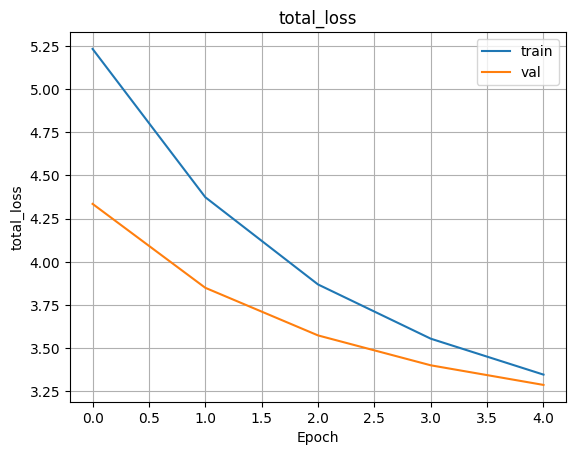

In [20]:
model = ZeroDCE()
model.compile(learning_rate=1e-4)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5)

# Plot losses
def plot_result(history, item):
    plt.plot(history.history[item], label='train')
    plt.plot(history.history['val_' + item], label='val')
    plt.title(item)
    plt.xlabel("Epoch")
    plt.ylabel(item)
    plt.legend()
    plt.grid()
    plt.show()

# Only total_loss was returned, so:
plot_result(history, "total_loss")

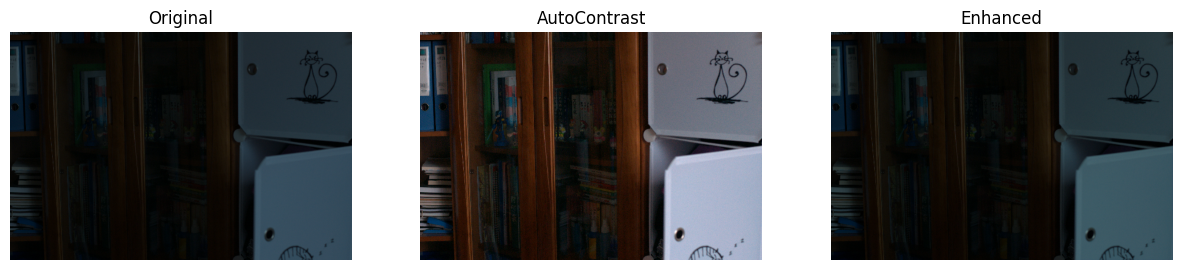

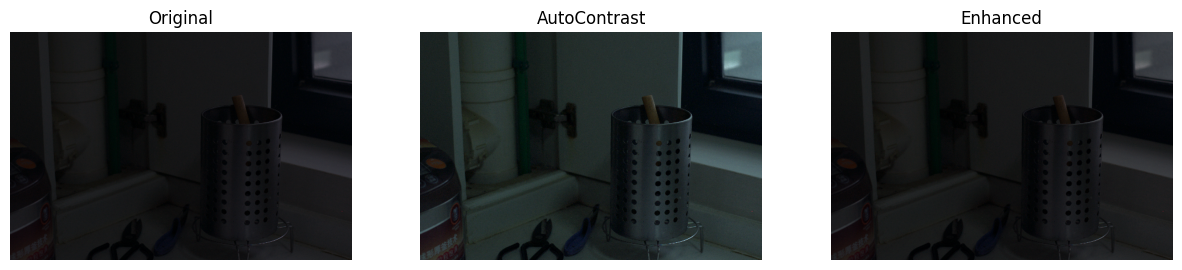

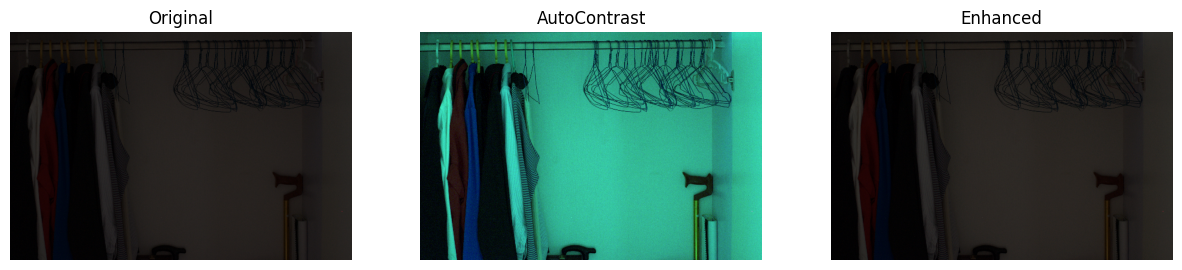

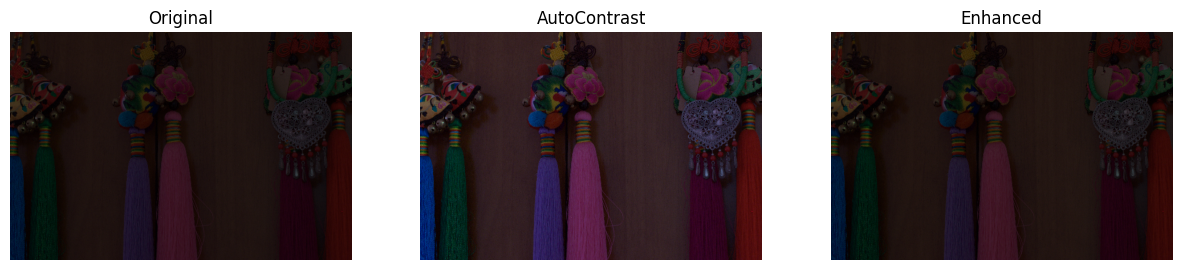

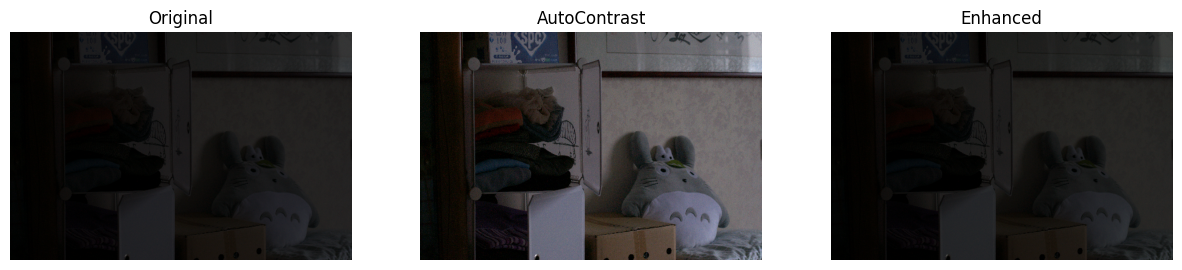

In [21]:
def infer(img):
    arr = keras.preprocessing.image.img_to_array(img).astype("float32") / 255.0
    arr = np.expand_dims(arr, axis=0)
    output = model(arr)
    out = tf.cast(output[0] * 255, dtype=tf.uint8).numpy()
    return Image.fromarray(out)

def show_samples():
    for i in range(5):
        low = Image.open(test_low_light_images[i])
        enhanced = infer(low)
        auto = ImageOps.autocontrast(low)

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        for ax, img, title in zip(axs, [low, auto, enhanced], ['Original', 'AutoContrast', 'Enhanced']):
            ax.imshow(img)
            ax.set_title(title)
            ax.axis('off')
        plt.show()

show_samples()


In [22]:
model.dce_model.save("LOW_LIGHT_MODEL.h5")
print("Model saved as LOW_LIGHT_MODEL.h5")

Model saved as LOW_LIGHT_MODEL.h5
